# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [8]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [10]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [6]:
def apk(relevant, predicted, k=20):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in relevant and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not relevant:
        return 0.0

    return score / min(len(relevant), k)


In [7]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    return np.mean([apk(a,p,k) for a,p in zip(relevant, predicted)])

In [8]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [14]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [15]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [16]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [17]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [18]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [14]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [15]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [19]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [17]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        scores = np.random.rand(self.n_items)
        return np.argsort(-scores)

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        for user_id in test_users:
            user_recommendations = self.recommend(user_id)
            test_preds.append(user_recommendations)

        filtered_test_preds = self.remove_train_items(test_preds, k)

        return filtered_test_preds

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [18]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    sim = np.zeros(ratings.shape[0])

    user_mean = np.mean(user_vector[user_vector > 0])
    user_centered = np.where(user_vector > 0, user_vector - user_mean, 0)

    for v in range(ratings.shape[0]):
        if np.any(user_vector) and np.any(ratings[v]):
            common_items = (user_vector > 0) & (ratings[v] > 0)
            if np.any(common_items):
                v_mean = np.mean(ratings[v][common_items])
                v_centered = np.where(ratings[v] > 0, ratings[v] - v_mean, 0)

                numerator = np.dot(user_centered[common_items], v_centered[common_items])
                denominator = np.sqrt(np.dot(user_centered[common_items], user_centered[common_items])) * \
                              np.sqrt(np.dot(v_centered[common_items], v_centered[common_items]))

                if denominator != 0:
                    sim[v] = numerator / denominator

    return sim

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    sim = np.zeros(ratings.shape[0])

    for v in range(ratings.shape[0]):
        if np.any(user_vector) and np.any(ratings[v]):
            intersection = np.sum((user_vector > 0) & (ratings[v] > 0))
            union = np.sum((user_vector > 0) | (ratings[v] > 0))
            if union != 0:
                sim[v] = intersection / union

    return sim


**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [19]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vector = self.R[uid]

        similarities = self.similarity(user_vector)

        neighbors = np.where(similarities > self.alpha)[0]

        pred_ratings = np.zeros(self.n_items)
        for item in range(self.n_items):
            numerator = 0.0
            denominator = 0.0
            for neighbor in neighbors:
                numerator += similarities[neighbor] * self.R[neighbor, item]
                denominator += np.abs(similarities[neighbor])
            if denominator > 0:
                pred_ratings[item] = numerator / denominator

        already_rated = np.where(user_vector > 0)[0]
        pred_ratings[already_rated] = -np.inf

        recommended_tracks = np.argsort(pred_ratings)[::-1]

        return recommended_tracks

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [20]:
pearson_model = User2User(train_ratings, pearson)
jaccard_model = User2User(train_ratings, jaccard)

In [21]:
def get_recommendations(model, k_values, test_users):
    recommendations = []
    for k in k_values:
        model_recommendations = []
        for uid in test_users:
            recommended_tracks = model.recommend(uid)[:k]
            model_recommendations.append(recommended_tracks)
        recommendations.append(model_recommendations)
    return recommendations

In [22]:
k_values = [5, 10, 15, 20, 25, 30]
pearson_recommendations = get_recommendations(pearson_model, k_values, test_users)
jaccard_recommendations = get_recommendations(jaccard_model, k_values, test_users)

In [23]:
def get_random_recommendations(n_users, n_items, k_values):
    recommendations = []
    for k in k_values:
        random_recommendations = []
        for _ in range(n_users):
            recommended_tracks = np.random.choice(n_items, k, replace=False)
            random_recommendations.append(recommended_tracks)
        recommendations.append(random_recommendations)
    return recommendations

In [24]:
n_users = len(test_users)
n_items = train_ratings['trackId'].nunique()
random_recommendations = get_random_recommendations(n_users, n_items, k_values)

In [25]:
def calculate_mapk(recommendations, test_relevant, k_values):
    mapk_values = []
    for k, recs in zip(k_values, recommendations):
        mapk_values.append(mapk(test_relevant, recs, k))
    return mapk_values

In [26]:
test_relevant = [test_ratings[test_ratings['userId'] == user_id]['trackId'].tolist() for user_id in test_users]

pearson_mapk = calculate_mapk(pearson_recommendations, test_relevant, k_values)
jaccard_mapk = calculate_mapk(jaccard_recommendations, test_relevant, k_values)
random_mapk = calculate_mapk(random_recommendations, test_relevant, k_values)

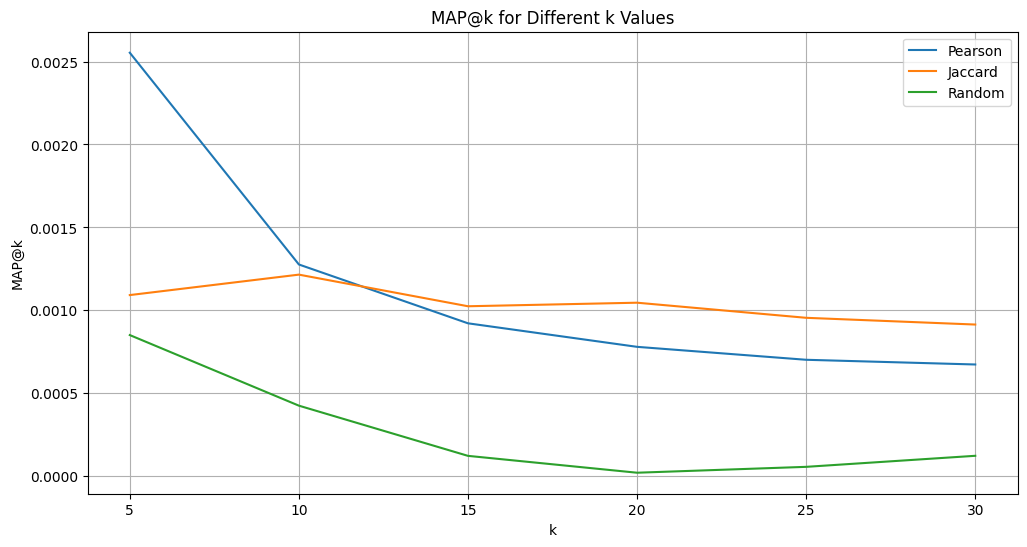

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, pearson_mapk, label='Pearson')
plt.plot(k_values, jaccard_mapk, label='Jaccard')
plt.plot(k_values, random_mapk, label='Random')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Для каждой из моделей получился достаточно ноизкий Мап@к, очень интересно что для всех значений k
# значение опусалось ниже 0,0026

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [47]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = ratings['userId'].nunique()
        self.n_items = ratings['trackId'].nunique()

        self.R = csr_matrix((np.ones(len(ratings)), (ratings['userId'], ratings['trackId'])),
                            shape=(self.n_users, self.n_items))

    def recommend(self, uid: int):
        raise NotImplementedError

    def remove_train_items(self, preds: np.array, k: int):
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        return test_preds[test_users]

In [68]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm
from scipy.sparse.linalg import norm as sparse_norm
from numpy.linalg import norm as dense_norm

In [67]:
def pearson(ratings: csr_matrix, user_vector: csr_matrix) -> np.array:
    sim = np.zeros(ratings.shape[0])

    user_vector = user_vector.toarray().flatten()
    user_mean = user_vector[user_vector > 0].mean() if np.any(user_vector > 0) else 0
    user_centered = user_vector - user_mean

    for v in range(ratings.shape[0]):
        if not np.array_equal(ratings[v].toarray().flatten(), user_vector):
            neighbor_vector = ratings[v].toarray().flatten()
            if np.any(neighbor_vector > 0):
                common_items = (user_vector > 0) & (neighbor_vector > 0)
                if np.any(common_items):
                    neighbor_mean = neighbor_vector[common_items].mean()
                    neighbor_centered = neighbor_vector - neighbor_mean
                    numerator = (user_centered[common_items] * neighbor_centered[common_items]).sum()
                    denominator = dense_norm(user_centered[common_items]) * dense_norm(neighbor_centered[common_items])
                    if denominator != 0:
                        sim[v] = numerator / denominator

    return sim

In [69]:
def jaccard(ratings: csr_matrix, user_vector: csr_matrix) -> np.array:
    sim = np.zeros(ratings.shape[0])

    user_items = set(user_vector.nonzero()[1])

    for v in range(ratings.shape[0]):
        if not np.array_equal(ratings[v].toarray().flatten(), user_vector):
            neighbor_items = set(ratings[v].nonzero()[1])
            intersection = len(user_items & neighbor_items)
            union = len(user_items | neighbor_items)
            if union != 0:
                sim[v] = intersection / union

    return sim

In [70]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vector = self.R.getrow(uid)
        similarities = self.similarity(user_vector)
        neighbors = np.where(similarities > self.alpha)[0]

        pred_ratings = np.zeros(self.n_items)
        for item in range(self.n_items):
            numerator = 0.0
            denominator = 0.0
            for neighbor in neighbors:
                numerator += similarities[neighbor] * self.R[neighbor, item]
                denominator += abs(similarities[neighbor])
            if denominator > 0:
                pred_ratings[item] = numerator / denominator

        already_rated = user_vector.nonzero()[1]
        pred_ratings[already_rated] = -np.inf

        recommended_tracks = np.argsort(pred_ratings)[::-1]

        return recommended_tracks

In [36]:
def get_recommendations(model, k_values, test_users):
    recommendations = []
    for k in k_values:
        model_recommendations = []
        for uid in test_users:
            recommended_tracks = model.recommend(uid)[:k]
            model_recommendations.append(recommended_tracks)
        recommendations.append(model_recommendations)
    return recommendations

In [37]:
k_values = [5, 10, 15, 20, 25, 30]

In [42]:
print(train_ratings.columns)
print(test_ratings.columns)

Index(['userId', 'trackId'], dtype='object')
Index(['userId', 'trackId'], dtype='object')


In [71]:
pearson_model = User2User(train_ratings, pearson)

In [72]:
jaccard_model = User2User(train_ratings, jaccard)

In [73]:
pearson_recommendations = get_recommendations(pearson_model, k_values, test_users)

In [75]:
def get_random_recommendations(n_users, n_items, k_values):
    recommendations = []
    for k in k_values:
        random_recommendations = []
        for _ in range(n_users):
            recommended_tracks = np.random.choice(n_items, k, replace=False)
            random_recommendations.append(recommended_tracks)
        recommendations.append(random_recommendations)
    return recommendations


In [76]:
n_users = len(test_users)
n_items = train_ratings['trackId'].nunique()
random_recommendations = get_random_recommendations(n_users, n_items, k_values)

In [77]:
def calculate_mapk(recommendations, test_relevant, k_values):
    mapk_values = []
    for k, recs in zip(k_values, recommendations):
        mapk_values.append(mapk(test_relevant, recs, k))
    return mapk_values

In [78]:
test_relevant = [test_ratings[test_ratings['userId'] == user_id]['trackId'].tolist() for user_id in test_users]

pearson_mapk = calculate_mapk(pearson_recommendations, test_relevant, k_values)
random_mapk = calculate_mapk(random_recommendations, test_relevant, k_values)

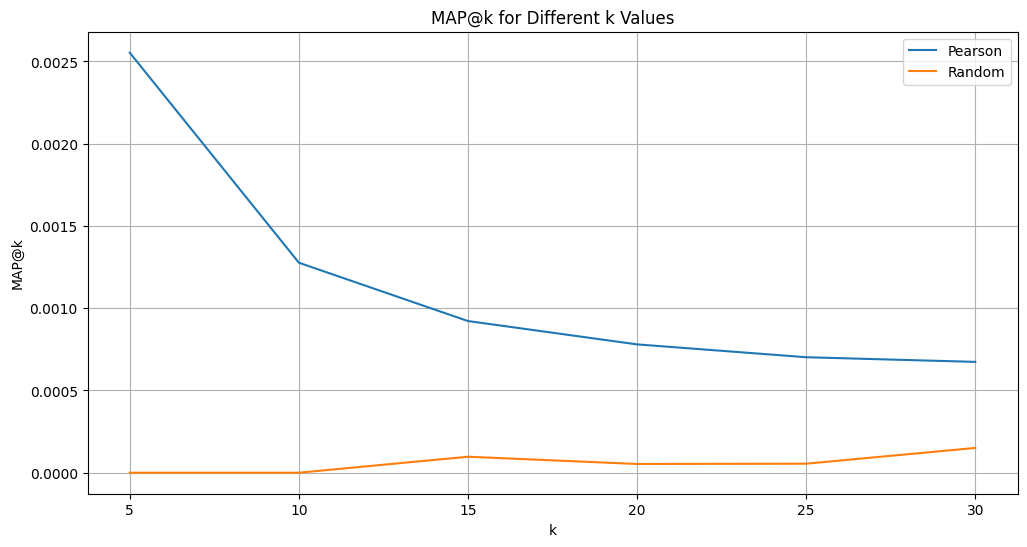

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, pearson_mapk, label='Pearson')
plt.plot(k_values, random_mapk, label='Random')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# по времени вышло как буд-то дольше, jaccard вообще не дождался

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [80]:
user_id = np.random.randint(0, pearson_model.n_users)

In [81]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
22,Down On The Corner,['Creedence Clearwater Revival']
23,Fortunate Son,['Creedence Clearwater Revival']
81,Ain't No Mountain High Enough,"['Marvin Gaye', 'Tammi Terrell']"
91,She's A Lady,['Tom Jones']
94,Iron Man,['Black Sabbath']
95,Paranoid,['Black Sabbath']
113,Just A Lil Bit,['50 Cent']
143,Word Up!,['Cameo']
145,(We're Gonna) Rock Around The Clock,['Bill Haley & His Comets']
189,Sweet Home Alabama,['Lynyrd Skynyrd']


In [84]:
k_values = 15
test_users = [user_id]
pearson_recommendations = get_recommendations(pearson_model, [k_values], test_users)

preds = pearson_recommendations[0][0]

print('Predicted tracks:')
print(tracks_info.loc[preds][['name', 'artists']])

Predicted tracks:
                             name                 artists
67312                     Послала  ['VAVAN', 'Real Girl']
22609            I Wanna Fuck You  ['Snoop Dogg', 'Akon']
22607        The Celebration Song      ['Brock Berrigan']
22606           We are the Hearts                ['EXGF']
22605                 Joan Of Arc             ['Madonna']
22604                    Ganjaman              ['Alfons']
22603                  Hold Tight             ['Madonna']
22602                     Megamix       ['Bad Boys Blue']
22601                 Take It All              ['Ruelle']
22600  Sex, Drugs & Rock -N- Roll              ['Saliva']
22599  Since I Told You It's Over       ['Stereophonics']
22598         High As The Ceiling       ['Stereophonics']
22597    You Stole My Money Honey       ['Stereophonics']
22596                Madame Helga       ['Stereophonics']
22595              Maybe Tomorrow       ['Stereophonics']


In [85]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
52782,Instagram,"['Dimitri Vegas & Like Mike', 'David Guetta', ..."
53771,Beverly Hills,['Zivert']
53891,Arriba,"['Little Big', 'Tatarka', 'Clean Bandit']"
54220,Roses,['SAINt JHN']
54689,Gitar,['Пётр Налич']
55166,Rock-Paper-Scissors,['Little Big']
55635,Ayy Macarena,['Tyga']
55706,Go Bananas,['Little Big']
55954,On My Mind,"['Diplo', 'SIDEPIECE']"
56672,Ordinary Man,"['Ozzy Osbourne', 'Elton John']"


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Ответ

\\
**ALS:**

Ответ



**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [3]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [4]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = ratings['userId'].nunique()
        self.n_items = ratings['trackId'].nunique()

        self.R = csr_matrix((np.ones(len(ratings)), (ratings['userId'], ratings['trackId'])),
                            shape=(self.n_users, self.n_items))

    def recommend(self, uid: int):
        raise NotImplementedError

    def remove_train_items(self, preds: np.array, k: int):
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        return test_preds[test_users]

In [6]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                self.sgd_step()
            elif self.mode == 'als':
                self.als_step()

    def sgd_step(self):
        for i, j in zip(*self.R.nonzero()):
            error = self.R[i, j] - np.dot(self.P[i, :], self.Q[j, :])
            self.P[i, :] += self.lr * (error * self.Q[j, :] - self.lamb * self.P[i, :])
            self.Q[j, :] += self.lr * (error * self.P[i, :] - self.lamb * self.Q[j, :])

    def als_step(self):
        for i in range(self.n_users):
            A = np.dot(self.Q.T, self.Q) + self.lamb * np.eye(self.dim)
            b = np.dot(self.R[i, :].toarray().flatten(), self.Q)
            self.P[i, :] = np.linalg.solve(A, b)

        for j in range(self.n_items):
            A = np.dot(self.P.T, self.P) + self.lamb * np.eye(self.dim)
            b = np.dot(self.R[:, j].T.toarray().flatten(), self.P)
            self.Q[j, :] = np.linalg.solve(A, b)

    def recommend(self, uid):
        pred_rating = np.dot(self.P[uid, :], self.Q.T)
        return np.argsort(pred_rating)[::-1]

In [ ]:
# hidden_vars_model = HiddenVars(train_ratings, dim=128, mode='sgd')
# hidden_vars_model.fit(num_iters=5)
# recommendations = hidden_vars_model.recommend(user_id)

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [11]:
def mapk(true_ratings, predicted_ratings, k):
    def apk(actual, predicted, k):
        if len(predicted) > k:
            predicted = predicted[:k]

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        if not actual:
            return 0.0

        return score / min(len(actual), k)

    return np.mean([apk(a, p, k) for a, p in zip(true_ratings, predicted_ratings)])

In [12]:
def get_test_recommendations(model, test_users, k):
    recommendations = []
    for uid in test_users:
        recommendations.append(model.recommend(uid)[:k])
    return recommendations

In [20]:
test_users = test_ratings['userId'].unique()
test_true_ratings = [test_ratings[test_ratings['userId'] == uid]['trackId'].tolist() for uid in test_users]

In [26]:
num_iters = 5
k_values = [15, 20, 25]

mapk_sgd = {k: [] for k in k_values}
mapk_als = {k: [] for k in k_values}

In [23]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm
from scipy.sparse.linalg import norm as sparse_norm
from numpy.linalg import norm as dense_norm

In [24]:
sgd_model = HiddenVars(train_ratings, dim=128, mode='sgd')
als_model = HiddenVars(train_ratings, dim=128, mode='als')

In [27]:
for epoch in range(1, num_iters + 1):
    sgd_model.fit(num_iters=1)
    als_model.fit(num_iters=1)

    for k in k_values:
        sgd_recommendations = get_test_recommendations(sgd_model, test_users, k)
        als_recommendations = get_test_recommendations(als_model, test_users, k)

        mapk_sgd[k].append(mapk(test_true_ratings, sgd_recommendations, k))
        mapk_als[k].append(mapk(test_true_ratings, als_recommendations, k))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
import matplotlib.pyplot as plt

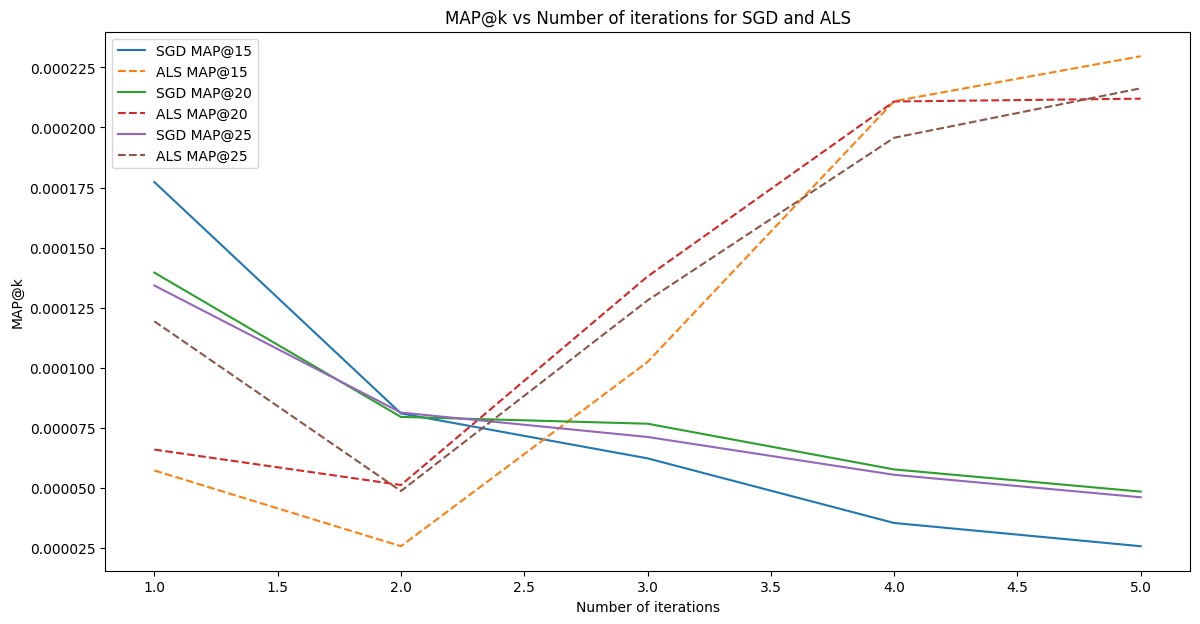

In [29]:
plt.figure(figsize=(14, 7))

for k in k_values:
    plt.plot(range(1, num_iters + 1), mapk_sgd[k], label=f'SGD MAP@{k}')
    plt.plot(range(1, num_iters + 1), mapk_als[k], label=f'ALS MAP@{k}', linestyle='--')

plt.xlabel('Number of iterations')
plt.ylabel('MAP@k')
plt.title('MAP@k vs Number of iterations for SGD and ALS')
plt.legend()
plt.show()

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [30]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = sgd_model.Q @ sgd_model.Q[example_trackId]
preds = preds / np.sqrt((sgd_model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [32]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(sgd_model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
21487,Не было такой,['Борис Гребенщиков'],0.371390
26795,В плену твоих рук,['Ирина Круг'],0.360616
31661,Forevermore,['BrunuhVille'],0.346817
19576,All of Me,"['John Legend', 'Jennifer Nettles', 'Hunter Ha...",0.340794
58391,delete,"[""M'Dee""]",0.331312
27237,Doctor Robert,['The Beatles'],0.321640
58447,123,['Luverance'],0.321257
52826,Прикосновение к Есенину,['Жанна Агузарова'],0.319403
65992,Habits (Stay High),"['Sarah Meow', 'beaurial']",0.318863


In [33]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = als_model.Q @ als_model.Q[example_trackId]
preds = preds / np.sqrt((als_model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [34]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(als_model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.781206
16637,Zodiac,['Zodiac'],0.751713
9689,Bicycle Race,['Queen'],0.751713
5153,Stormbringer,['Deep Purple'],0.751713
5570,Моё сердце,['Сплин'],0.711776
10714,Буги-вуги каждый день,['Зоопарк'],0.689725
11476,I Want It All,['Queen'],0.689725
16635,Pacific,['Zodiac'],0.689725
5005,Highway Star,['Deep Purple'],0.689725


In [ ]:
# ALS метод стабильно улучшает предсказания, так как решает линейные уравнения напрямую.
# Он может быстрее сходиться к хорошим результатам, особенно при большом объеме данных.